In [108]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pdb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import requests as req

from imblearn.over_sampling import SMOTE
# import bokeh
# from bokeh.io import output_notebook, show
# from bokeh.resources import INLINE
# import bokeh.plotting as bp
# from bokeh.plotting import figure
#output_notebook(resources=INLINE)



mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = [20,15]
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] =15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['legend.fontsize'] = 15
pd.options.mode.chained_assignment = None


PLT_WIDTH_INCH = 20
PLT_HEIGHT_INCH = 15
plt.rcParams['figure.figsize'] = [PLT_WIDTH_INCH, PLT_HEIGHT_INCH]

%load_ext autoreload
%matplotlib inline



#task specific modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LOAD DATA

In [5]:
#features correlation
all_features_from_spotify = pd.read_pickle('all_features_from_spotify_with_genres.dat')
popular_songs = pd.read_pickle('final_popular_songs.dat')
random_songs = pd.read_pickle('final_random_songs.dat')
all_songs = pd.read_pickle('final_all_songs.dat')
all_genres = list(pd.read_pickle('all_genres.dat')[0].values)
GENRES = list(pd.read_pickle('spotify_genres.dat')[0].values)

# FUNCTIONS

In [129]:
# %load spotify_client/spotify_client.py
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials


"""
we will get all the features from spotify, by song name and artist name.
this function will create a json file with all the data
"""
def get_song_features_and_info_json(song_name, artist_name):

    # getting credentials to request special API
    credenials = SpotifyClientCredentials(client_id="5659eaf41b194134866170761e2fb293",client_secret="17e2a9fa37c2466baa2ba05752896cdc")

    # getting the client
    spotify_client = spotipy.Spotify(client_credentials_manager=credenials)

    # getting the song id in order to retrieve features, limiting to 1 since it sorts the results by popularity
    song_results = spotify_client.search(q='artist:' + artist_name + ' track:' + song_name, type='track',limit=1)
    #print(song_results)
    tracks = song_results['tracks']['items']
    if len(tracks)==0:
        print("***no results for the requested track:{}***".format(song_name+":"+artist_name))
        return
    result_dict = tracks[0]

    # creating dict for track
    song_dict = creating_song_dictionary(artist_name, result_dict, spotify_client)

    return song_dict
def creating_song_dictionary(artist_name, result_dict, spotify_client):
    song_dict = {}
    song_dict['artist'] = artist_name
    song_id = [result_dict['uri']]
    song_dict['uri'] = song_id
    song_dict['year'] = result_dict['album']['release_date'][:4]
    song_dict['artist_id'] = result_dict['artists'][0]['id']
    song_dict['track_id'] = result_dict['id']
    song_dict['name'] = spotify_client.track(song_dict['track_id'])['name']
    song_dict['popularity'] = result_dict['popularity']
    song_dict['preview_link'] = result_dict['preview_url']
    features = spotify_client.audio_features(song_id)
    song_dict['main_features'] = features[0]

    # todo - need this? a big analysis, maybe will be helpful
    # analysis = spotify_client._get(features[0]['analysis_url'])
    #
    # song_dict['analysis'] = analysis

    return song_dict



SPOTIFY_COLUMNS = ['artist','artist_id','name','genre','decade','duration_ms','acousticness',
                  'danceability','energy','id',
                  'instrumentalness','liveness','loudness','speechiness','tempo','valence','popular']


selected_columns=['duration_ms','acousticness',
                  'danceability','energy',
                  'instrumentalness','liveness','loudness','speechiness','tempo','valence']

def plot_statistics(df,column='num_words'):
    df.groupby('decade')[column].describe().T.plot(kind='box',title='{}'.format(column),figsize=(10,5))
    
    
def get_artist_and_title(df):
    #return ["{}:{}".format(tup[0],tup[1]) for tup in list(zip(zz.loc['artist'].values,zz.loc['title'].values))]
    return list(zip(df.loc[:,'name'].values,df.loc[:,'artist'].values))



def scale_features(data):
    scaler = StandardScaler(with_mean=True)
    return pd.DataFrame(scaler.fit_transform(data))



# getting credentials to request special API
credenials = SpotifyClientCredentials(client_id="5659eaf41b194134866170761e2fb293",client_secret="17e2a9fa37c2466baa2ba05752896cdc")

# getting the client
spotify_client = spotipy.Spotify(client_credentials_manager=credenials)

import re

def get_artist_genre(spotify_client,artist_id):
    artist_data = spotify_client.artist(artist_id)
    spotify_genres = artist_data["genres"]
    return spotify_genres

def get_number_of_apearence(genre,spotify_genres):
    count=0
    for spot_genre in spotify_genres:
        res = re.search(genre, spot_genre)
        if res:
            count+=1
    return count

def get_genres_scores_of_artist(spotify_client,artist_id):
    artist_genres=get_artist_genre(spotify_client,artist_id)
    return [get_number_of_apearence(genre,artist_genres) for genre in GENRES]

def get_genre_of_artist(spotify_client,artist_id):
    scores=get_genres_scores_of_artist(spotify_client,artist_id)
    if np.sum(scores)==0:
        return 'na'
    return GENRES[np.argmax(scores)]



def remove_dup_songs_from_random(all_songs_data_frame,subset):
    res=all_songs_data_frame.drop_duplicates(subset = subset,keep = 'first',inplace = False)
    return res


def get_year(artist,title):
    try:
        res=req.get('https://api.discogs.com/database/search?artist={0}&release_title={1}&per_page=10&page=1&token=AVfnfICgSgXIDXAWivYivedRIhMcDRvYCxrIshPk'.format(artist,title))
        return np.min([np.int(r['year']) for r in res.json()['results'] if 'year' in r.keys()]) 
    except Exception as e:
        #print(e)
        return None
    
def get_all_fixed_years(data):
    years=[]
    details=get_artist_and_title(data)
    for name,artist in details:
        year=get_year(artist,name)
        years.append(year)
        print(year)
    return years

Preprocessig

In [4]:
#df=pd.read_pickle('billboard.dat')

def cleaning_and_typing(df):    
    df.columns=np.arange(df.shape[1])
    df['num_words']=df['num_words'].astype(int)
    df['num_lines']=df['num_lines'].astype(int)
    df['num_dupes']=df['num_dupes'].astype(int)

    df['title'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    df['artist'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    return df
    
def create_decade_mappings():
    all_years=np.arange(1950,2016)
    decades=np.arange(1950,2016,10)
    decades_mappings={}
    cur_dec=decades[0]
    cur_dec_idx=0
    for year in all_years:
        if year%cur_dec>=10:
            cur_dec_idx+=1
            cur_dec=decades[cur_dec_idx]
        decades_mappings.update({year:cur_dec})
    return decades_mappings



def spotify_preprocessing(df,is_popular=False):
    #add decade
    df['year']=df['year'].astype(int)
    zz=df['year'].map(create_decade_mappings())
    zz=zz.fillna(1950)
    df.loc[:,'decade']=zz.astype(int)
    
    #clean artists
    df['name'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    df['artist'].replace(regex=True,to_replace=r"\'",value=r'',inplace=True)
    
    #add genre information for each song
    df.loc[:,'genre']=df['artist_id'].apply(lambda artist_id:get_genre_of_artist(spotify_client,artist_id))
    
    #add popular column
    df.loc[:,'popular']=np.int(is_popular)
    
    #extract relevant columns only
    return df[SPOTIFY_COLUMNS]


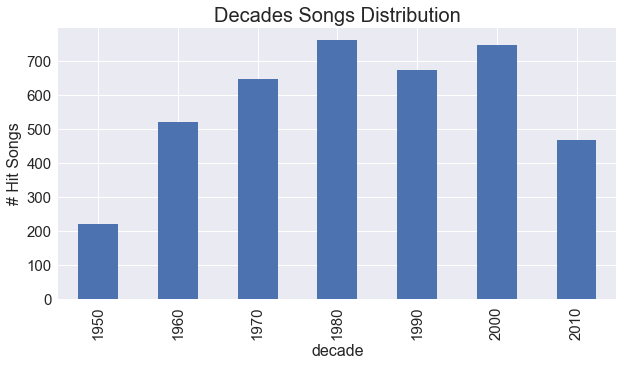

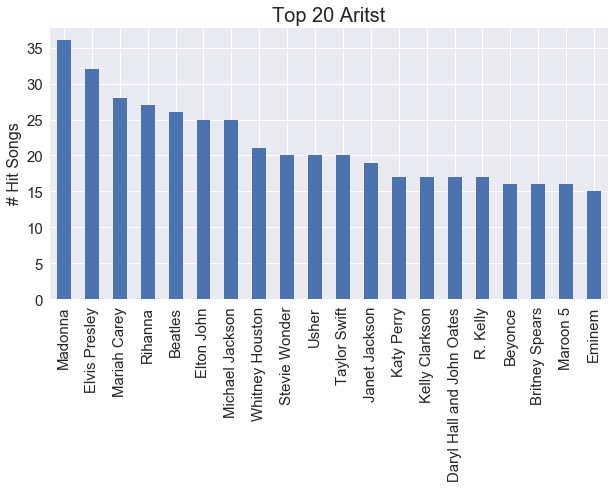

In [160]:
df.groupby('decade').apply(lambda decade: len(decade)).plot(kind='bar',figsize=(10,5),title='Decades Songs Distribution')
plt.ylabel('# Hit Songs')


plt.figure()
top_art=20
df['artist'].value_counts().head(top_art).plot(kind='bar',figsize=(10,5),title='Top {} Aritst'.format(top_art))
plt.ylabel('# Hit Songs')

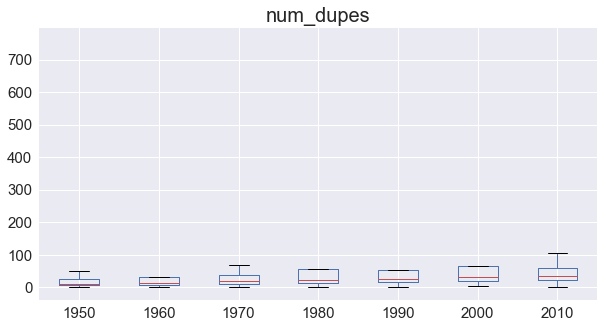

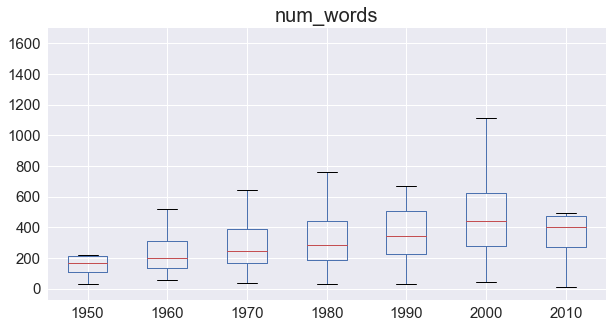

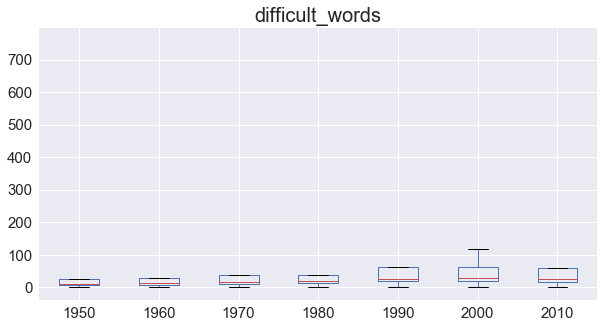

In [145]:
plot_statistics(df,'num_dupes')
plot_statistics(df,'num_words')
plot_statistics(df,'difficult_words')

In [7]:
title_art=get_artist_and_title(df.T)
songs_data=[]
missings=[]
count=0
start=696
for title,art in title_art[start:]:
    count+=1
    print(count)
    try:
        cur_song_features=get_song_features_and_info_json(title,art)
        if cur_song_features:
            songs_data.append(cur_song_features)
        else:
            missings.append(cur_song_features)
    except Exception as e:
        print(e)
        missings.append(cur_song_features)
    if(count%100)==0:
        print('Saving data..')
        pd.DataFrame(songs_data).to_pickle('songs_features_2.dat')

In [12]:
#kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7)
kmeans_data=all_features_from_spotify[selected_columns]
kmeans.fit(kmeans_data)
labels = kmeans.predict(kmeans_data)



In [95]:
clrs={0:'r',1:'b',2:'g',3:'y',4:'magenta',5:'cyan',6:'brown'}
kmeans_clrs = [clrs[idx] for idx in labels]


In [96]:
clrs={1950:'r',1960:'b',1970:'g',1980:'y',1990:'magenta',2000:'cyan',2010:'brown'}
decade_clrs = [clrs[row[1]['decade']] for row in all_features_from_spotify.iterrows()]

In [97]:
rand_colors=np.random.rand(3,len(GENRES))
genres_clrs = [rand_colors[:,GENRES.index(row[1]['genre'])] for row in all_features_from_spotify.iterrows()]

In [17]:
def scale_features(data):
    scaler = StandardScaler(with_mean=True)
    return pd.DataFrame(scaler.fit_transform(data))

In [16]:
selected_columns=['duration_ms','acousticness',
                  'danceability','energy',
                  'instrumentalness','liveness','loudness','speechiness','tempo','valence']

In [18]:
#features correlation
all_features_from_spotify[selected_columns].corr().style.background_gradient()

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
duration_ms,1,-0.294498,0.0957998,0.108753,0.0635969,-0.0496627,0.0685393,0.0419624,-0.0342163,-0.17398
acousticness,-0.294498,1,-0.32467,-0.607421,-0.0287821,0.0280361,-0.460683,-0.167622,-0.104749,-0.192838
danceability,0.0957998,-0.32467,1,0.240462,0.0491928,-0.131276,0.153252,0.202224,-0.146093,0.483663
energy,0.108753,-0.607421,0.240462,1,0.0260113,0.109151,0.733278,0.174271,0.158553,0.391625
instrumentalness,0.0635969,-0.0287821,0.0491928,0.0260113,1,-0.00755197,-0.0543121,-0.0338983,-0.00532828,0.0358425
liveness,-0.0496627,0.0280361,-0.131276,0.109151,-0.00755197,1,0.0531086,0.110456,0.0260017,0.020246
loudness,0.0685393,-0.460683,0.153252,0.733278,-0.0543121,0.0531086,1,0.163437,0.0811568,0.093125
speechiness,0.0419624,-0.167622,0.202224,0.174271,-0.0338983,0.110456,0.163437,1,0.0378851,0.0993988
tempo,-0.0342163,-0.104749,-0.146093,0.158553,-0.00532828,0.0260017,0.0811568,0.0378851,1,0.0812276
valence,-0.17398,-0.192838,0.483663,0.391625,0.0358425,0.020246,0.093125,0.0993988,0.0812276,1


we can see we have expected correlation between energy and loudness, but nothing more.

In [262]:
#PCA
from sklearn.decomposition import PCA

pca_data=all_features_from_spotify[selected_columns]

#make std=1 and mean=0
pca_data = scale_features(pca_data)

N=3
pca = PCA(n_components=N,svd_solver='full')
pca.fit(pca_data)

X_pca = pca.transform(pca_data)


In [146]:
#with genre 
#PCA
from sklearn.decomposition import PCA

selected=selected_columns.copy()
selected.append('decade')
all_features_from_spotify['genre_id']=all_features_from_spotify['genre'].apply(lambda x: GENRES.index(x))
pca_data=all_features_from_spotify[selected]

#make std=1 and mean=0
pca_data = scale_features(pca_data)

N=3
pca = PCA(n_components=N,svd_solver='full')
pca.fit(pca_data)

X_pca = pca.transform(pca_data)


c:\users\melgu_000\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:590: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  
c:\users\melgu_000\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [147]:
print(pca.components_)

[[-0.13283892  0.46054381 -0.30255111 -0.51053882 -0.00475079 -0.02885461
  -0.45690964 -0.22069278 -0.08148003 -0.24834486 -0.30236586]
 [ 0.29475536 -0.0761817  -0.48873162  0.00911312 -0.14708216  0.12671993
   0.24148517  0.0067373   0.10501098 -0.65709068  0.3598985 ]
 [ 0.52734585 -0.14867642  0.32882744 -0.19373754  0.19357118 -0.47539555
  -0.14225218 -0.05205508 -0.46611541 -0.1912104   0.11789326]]


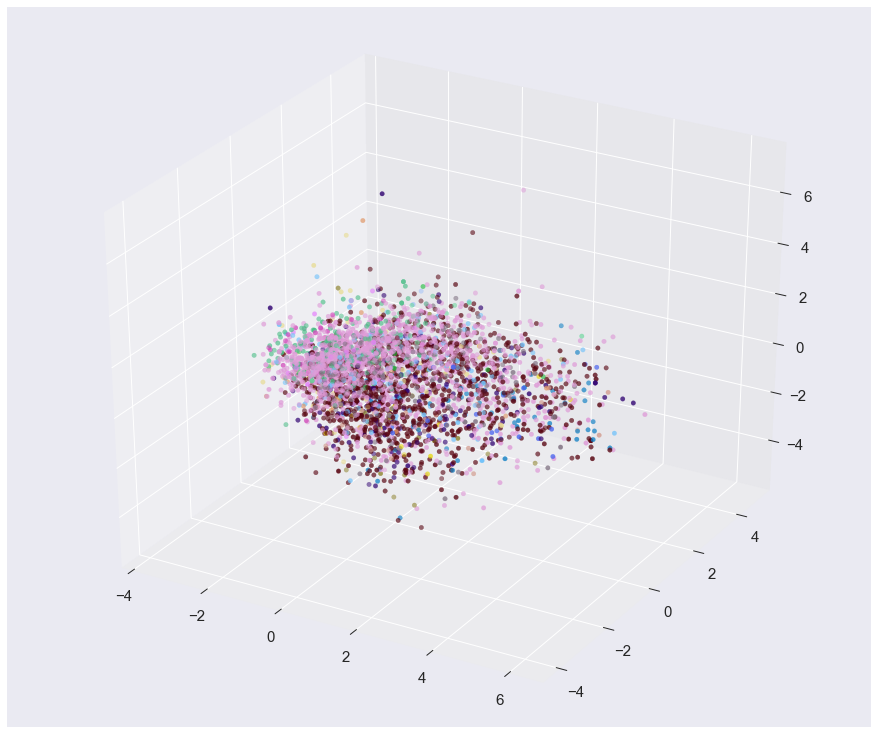

In [148]:
fig=plt.figure(figsize=(12, 10))
#plt.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=decade_clrs)
#plt.title('PCA - Color by decades')
ax = Axes3D(fig)
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=genres_clrs,s=20)

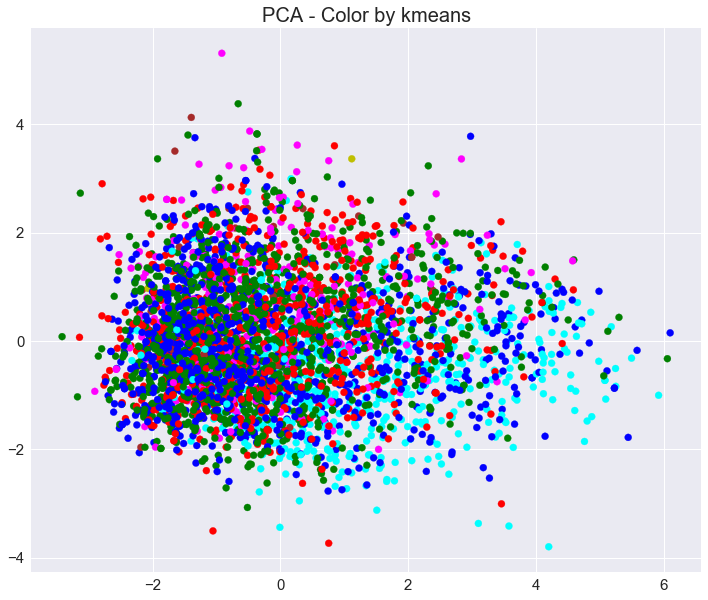

In [331]:
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:,0],X_pca[:,1],c=kmeans_clrs)
plt.title('PCA - Color by kmeans')

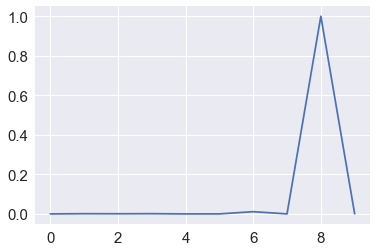

In [219]:
plt.plot(abs(pca.components_[1]))

## Get all genres from everynoise

In [27]:
# import requests
# from bs4 import BeautifulSoup
# url = 'http://everynoise.com/everynoise1d.cgi?scope=all'
# r = requests.get(url)
# html_content = r.text
# soup = BeautifulSoup(html_content, 'lxml')

# links=soup.find_all("a", {"title": "Re-sort the list starting from here."})
# all_genres=[link.text for link in links]



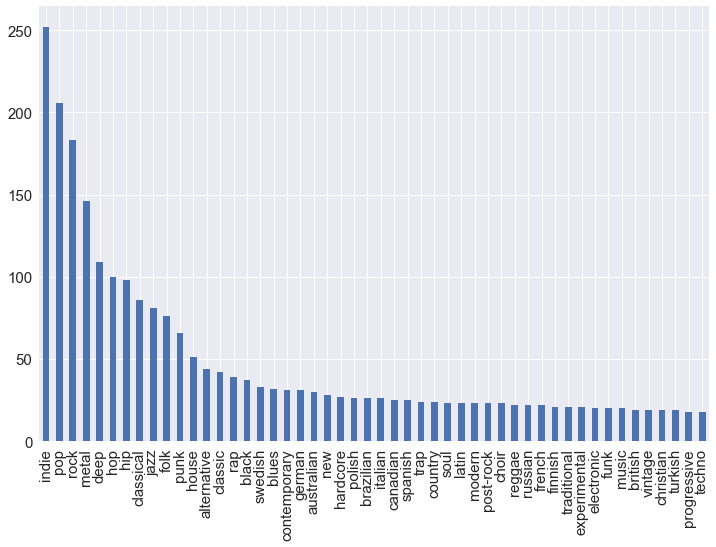

In [25]:
import itertools
splitted_genres=[gen.split() for gen in all_genres]

splitted_genres = list(itertools.chain(*splitted_genres))

pd.DataFrame(splitted_genres)[0].value_counts().head(50).plot(kind='bar',figsize=(12,8))

In [26]:
TOP_GENRES=20
GENRES=list(pd.DataFrame(splitted_genres)[0].value_counts().head(TOP_GENRES).keys())
#fix hip and hop
GENRES=[g for g in GENRES if g not in ['hip','hop']]
GENRES+=['country','christmas','disco','funk','soul','na','hip hop']
GENRES

['indie',
 'pop',
 'rock',
 'metal',
 'deep',
 'classical',
 'jazz',
 'folk',
 'punk',
 'house',
 'alternative',
 'classic',
 'rap',
 'black',
 'swedish',
 'blues',
 'contemporary',
 'german',
 'country',
 'christmas',
 'disco',
 'funk',
 'soul',
 'na',
 'hip hop']

In [240]:
# #add genre information for each song
# all_features_from_spotify['genre']=all_features_from_spotify['artist_id'].apply(lambda artist_id:get_genre_of_artist(spotify_client,artist_id))

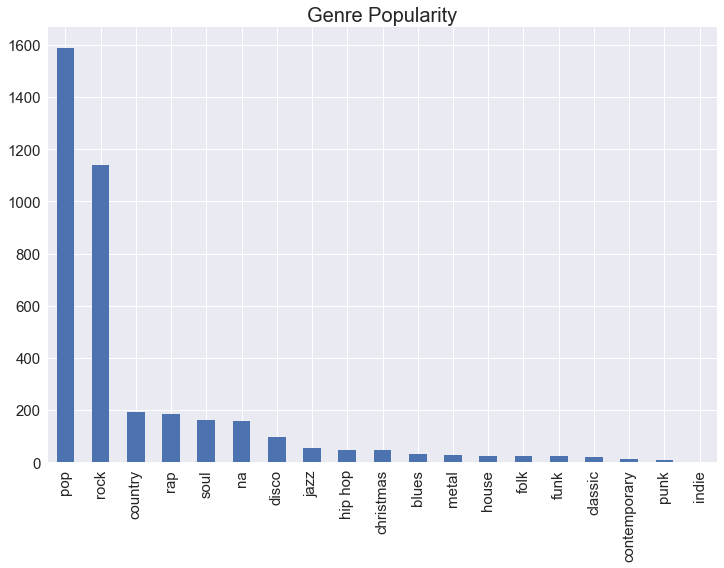

In [241]:
#genres distribution
all_features_from_spotify['genre'].value_counts().plot(kind='bar',title='Genre Popularity',figsize=(12,8))

## Merge data with hanit

In [79]:
random_songs_old = pd.read_pickle('final_random_songs.dat')
popular_songs = pd.read_pickle('final_popular_songs.dat')

In [100]:
#merge

frames= [popular_songs, random_songs]
all_songs_data = pd.concat(frames)


def remove_dup_songs_from_random(all_songs_data_frame,subset):
    res=all_songs_data_frame.drop_duplicates(subset = subset,keep = 'first',inplace = False)
    return res

all_songs_wo_dups = remove_dup_songs_from_random(all_songs_data,['name','artist'])
all_songs_wo_dups

,acousticness,artist,artist_id,danceability,decade,duration_ms,energy,genre,id,instrumentalness,liveness,loudness,name,popular,speechiness,tempo,valence
0,0.903000,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,0.214,1990,207573,0.1940,jazz,3k5ycyXX5qsCjLd7R2vphp,0.000001,0.1070,-15.636,Mona Lisa,1,0.0325,86.198,0.3390
1,0.930000,Andrews Sisters,2NCGI6dLTxLdI9XHdv7QfM,0.387,2000,198000,0.0958,jazz,6vSKLIxqiYllqDd2VcGVHv,0.000000,0.1700,-12.278,I Wanna Be Loved - Single Version,1,0.0391,167.122,0.2240
2,0.971000,Patti Page,4nZN9kln8toEzOifhWG2uF,0.475,1960,185000,0.1390,pop,0788TdvEjGtjFVb6CTFdJH,0.000173,0.1280,-12.619,Tennessee Waltz,1,0.0333,86.156,0.3740
3,0.795000,Tennessee Ernie Ford,7by3Je8PERsotbZ7xLWaDH,0.703,2010,156987,0.1970,na,1v52YkW75eN4RJ2EyDdQVI,0.000000,0.0982,-11.312,I'll Never Be Free,1,0.0327,82.114,0.4690
4,0.886000,Patti Page,4nZN9kln8toEzOifhWG2uF,0.608,1990,194333,0.1970,pop,2BNPXyUhq5WFpAO1Ff5yEg,0.000001,0.1140,-14.830,All My Love,1,0.0446,123.357,0.6390
5,0.910000,Perry Como,5v8jlSmAQfrkTjAlpUfWtu,0.645,1980,174040,0.4300,pop,12WJhNxX6EYC2rAlfVOW4d,0.000000,0.5610,-11.916,Hoop-Dee-Doo,1,0.0444,132.643,0.9440
6,0.896000,Bing Crosby,6ZjFtWeHP9XN7FeKSUe80S,0.778,1990,160750,0.2910,christmas,28IBsttOK2aG9Cb4QtqhMr,0.000514,0.1470,-12.703,Dear Hearts And Gentle People,1,0.0390,107.730,0.6950
7,0.824000,Frankie Laine,3cgO5CdhEHKMxldjZlP5ix,0.637,2010,174813,0.2750,pop,4Gx5Hy6fnfeXcSEnVls6f3,0.000000,0.2390,-12.261,The Cry of the Wild Goose,1,0.0386,80.044,0.4540
8,0.805000,Nat King Cole,7v4imS0moSyGdXyLgVTIV7,0.201,1990,204627,0.2130,jazz,0zII0Soax7wbm3Avw7iVAd,0.000082,0.1260,-14.531,Too Young,1,0.0298,96.324,0.2030
9,0.940000,Tony Bennett,2lolQgalUvZDfp5vvVtTYV,0.248,2000,242040,0.2200,jazz,1hVEHu6SemMvlYAP5MWkDj,0.001970,0.1090,-10.768,Because of You,1,0.0299,71.377,0.1910


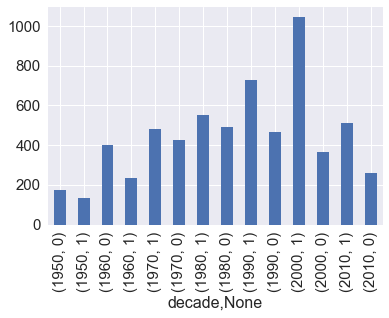

In [36]:
all_songs.groupby('decade').apply(lambda x:x['popular'].value_counts()).plot(kind='bar')

In [23]:
get_all_fixed_years(all_songs.head(5))

1
'results'
2
3
'results'
4
'results'
5


[1972, None, 1963, None, None]

In [79]:
def evaluate_models(features,labels,models,scoring_method='accuracy',CV=5):
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model,features, labels, scoring=scoring_method, cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', scoring_method])
    sns.boxplot(x='model_name', y=scoring_method, data=cv_df)
    sns.stripplot(x='model_name', y=scoring_method, data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.title('Scoring Method={}'.format(scoring_method))
    plt.xticks(rotation=45)
    a=plt.show()
    print(cv_df.groupby('model_name')[scoring_method].mean())
    return cv_df


def evaluate_model_stats(model,X_train, X_test, y_train, y_test,train=True):
    if train:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
   # sns.heatmap(conf_mat, annot=True, fmt='d',
                #xticklabels=AUTHOR_ID.keys(), yticklabels=AUTHOR_ID.keys())
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("{} Confusion Martix".format(model.__class__.__name__))

    print(metrics.classification_report(y_test, y_pred, target_names=['No-Popular','Popular']))

    #calculate log-loss
    print("{}:Log-Loss:{}".format(model.__class__.__name__,log_loss(y_test,y_pred_probs)))
    return model,y_pred,y_pred_probs,conf_mat


#Using Accuracy
models = [
    #LinearSVC(),
    #MultinomialNB(),
    LogisticRegression(solver='sag',random_state=0),
]

#accuracy_cv_df=evaluate_models(features,labels,models,scoring_method='accuracy')


#Using Neg-Log-Loss
models_2 = [
    MultinomialNB(),
    LogisticRegression(solver='sag',random_state=0)
]

#log_loss_cv_df = evaluate_models(features,labels,models_2,scoring_method='neg_log_loss')

In [83]:
decade = 2000
data=all_songs[all_songs['decade']==decade]
data.loc[:,'genre_id']=data['genre'].map(lambda x: GENRES.index(x))
selected = selected_columns
selected.append('genre_id')
labels=data['popular'].values
filtered_data = data[selected_columns]

scaled_data=scale_features(filtered_data)

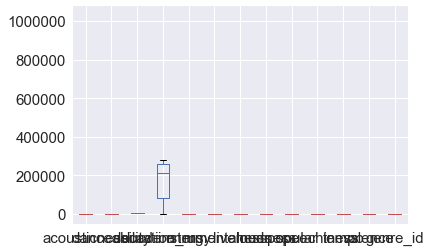

In [64]:
data.describe().plot(kind='box')

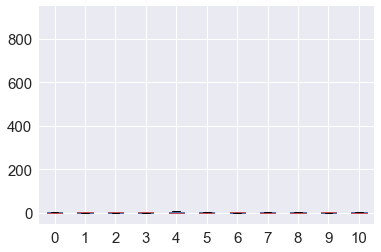

In [66]:
scaled_data.describe().plot(kind='box')

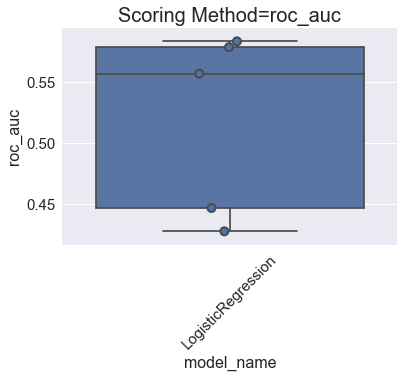

model_name
LogisticRegression    0.518764
Name: roc_auc, dtype: float64


In [103]:
smt=SMOTE()

accuracy_cv_df=evaluate_models(scaled_data,labels,models,scoring_method='roc_auc')

             precision    recall  f1-score   support

 No-Popular       0.80      0.06      0.11        71
    Popular       0.76      1.00      0.86       211

avg / total       0.77      0.76      0.67       282

LogisticRegression:Log-Loss:0.5369095805045476


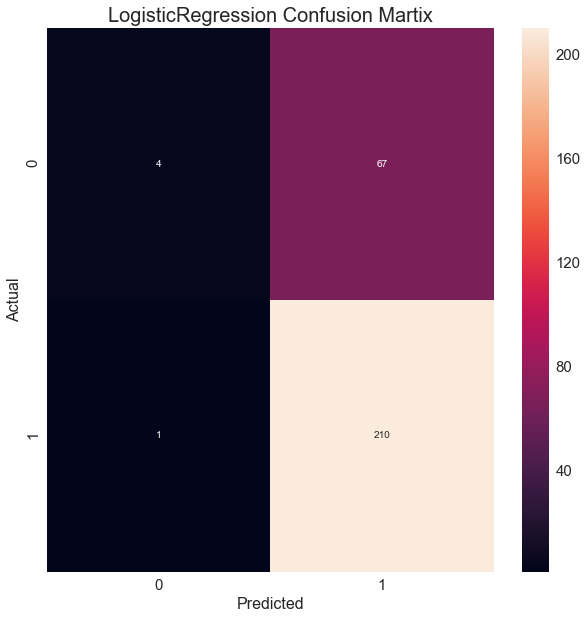

In [85]:
#split train/test the vectorized features
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(scaled_data, labels, scaled_data.index, test_size=0.20, random_state=0)




#Logit model
model = LogisticRegression(solver='sag',random_state=0)
z=evaluate_model_stats(model,X_train, X_test, y_train, y_test)

# #NB Model
# model = MultinomialNB()
# z=evaluate_model_stats(model,X_train, X_test, y_train, y_test)
